In [62]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [63]:
with open('models/rf_home.pkl', 'rb') as f:
    home_md = pickle.load(f)

with open('models/rf_away.pkl', 'rb') as f:
    away_md = pickle.load(f)

In [64]:
teams_data = pd.read_csv("data/new_model.csv")

In [65]:
def find_team_features(home, away):
    home_infos = teams_data[(teams_data.home_team == home) | (teams_data.away_team == home)].tail(1)
    if home_infos.home_team.values[0] == home:
        home_goals_scored = home_infos["home_goals_mean"].values[0]
        home_goals_suf = home_infos["home_goals_suf_mean"].values[0]
        home_points_made = home_infos["home_game_points_mean"].values[0]
        home_rank = home_infos["rank_home"].values[0]
    else:
        home_goals_scored = home_infos["away_goals_mean"].values[0]
        home_goals_suf = home_infos["away_goals_suf_mean"].values[0]
        home_points_made = home_infos["away_game_points_mean"].values[0]
        home_rank = home_infos["rank_away"].values[0]
        
    
    away_infos = teams_data[(teams_data.home_team == away) | (teams_data.away_team == away)].tail(1)
    if away_infos.home_team.values[0] == away:
        away_goals_scored = away_infos["home_goals_mean"].values[0]
        away_goals_suf = away_infos["home_goals_suf_mean"].values[0]
        away_points_made = away_infos["home_game_points_mean"].values[0]
        away_rank = away_infos["rank_home"].values[0]
    else:
        away_goals_scored = away_infos["away_goals_mean"].values[0]
        away_goals_suf = away_infos["away_goals_suf_mean"].values[0]
        away_points_made = away_infos["away_game_points_mean"].values[0]
        away_rank = away_infos["rank_away"].values[0]

    #print(home_rank, away_rank)
    rank_dif = home_rank - away_rank
    ht_features = [
        home_goals_scored*rank_dif,
        away_goals_suf*rank_dif,
        home_points_made*rank_dif,
        away_points_made*rank_dif
    ]
    
    at_features = [
        away_goals_scored*rank_dif,
        home_goals_suf*rank_dif,
        home_points_made*rank_dif,
        away_points_made*rank_dif
    ]
    return ht_features, at_features

In [133]:
g, s = find_team_features("Italy", "Albania")

In [134]:
xg_g = home_md.predict([g])[0]

In [135]:
xg_s = away_md.predict([s])[0]

In [136]:
from scipy.stats import poisson

In [137]:
poisson_probs_g = poisson.pmf(np.arange(0, 10), xg_g)
poisson_probs_s = poisson.pmf(np.arange(0, 10), xg_s)

In [138]:
def plot_poisson(x, poisson_probs, team):
    plt.figure(figsize=(10, 6))
    plt.bar(x, poisson_probs, alpha=0.6, color='blue')
    plt.plot(x, poisson_probs, 'bo', ms=8)
    plt.title(f'Poisson Distribution - {team}')
    plt.xlabel('Number of Events')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

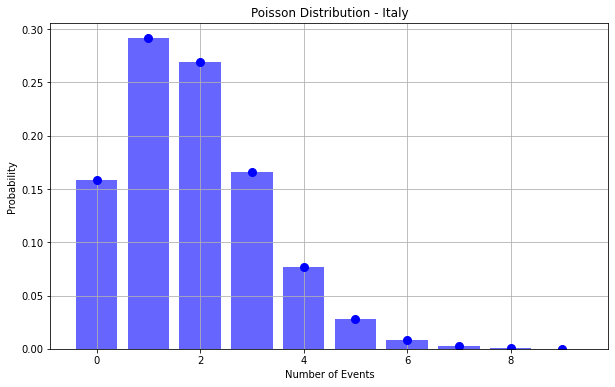

In [139]:
plot_poisson(np.arange(0,10), poisson_probs_g, "Italy")

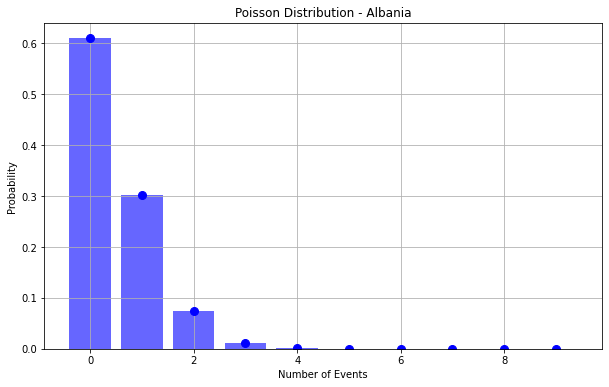

In [140]:
plot_poisson(np.arange(0,10), poisson_probs_s, "Albania")

In [141]:
res_track = np.zeros((10,10))

for i in range(len(poisson_probs_g)):
    for j in range(len(poisson_probs_s)):
        res_prob = poisson_probs_g[i]*poisson_probs_s[j]
        res_track[j][i] = res_prob

In [142]:
poisson_probs_g

array([1.57956616e-01, 2.91498646e-01, 2.68970883e-01, 1.65456082e-01,
       7.63346055e-02, 2.81741085e-02, 8.66558035e-03, 2.28453773e-03,
       5.26995698e-04, 1.08059582e-04])

In [143]:
poisson_probs_s

array([6.10015107e-01, 3.01513116e-01, 7.45146786e-02, 1.22768287e-02,
       1.51702181e-03, 1.49964146e-04, 1.23538353e-05, 8.72307057e-07,
       5.38945708e-08, 2.95983927e-09])

In [144]:
res_df = pd.DataFrame(res_track)

In [146]:
res_df.columns = ["Italy " + str(a) for a in res_df.columns] 
res_df.index = ["Albania " + str(a) for a in res_df.index] 

In [147]:
def style_specific_cells(x):
    color = ''
    
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if i == j:
                color = 'background-color: yellow'
            elif j > i:
                color = 'background-color: green'
            else:
                color = 'background-color: lightcoral'
            df_styled.iloc[i, j] = color
    return df_styled


In [148]:
res_df.style.format("{:.2%}").apply(style_specific_cells, axis=None)

,Italy 0,Italy 1,Italy 2,Italy 3,Italy 4,Italy 5,Italy 6,Italy 7,Italy 8,Italy 9
Albania 0,9.64%,17.78%,16.41%,10.09%,4.66%,1.72%,0.53%,0.14%,0.03%,0.01%
Albania 1,4.76%,8.79%,8.11%,4.99%,2.30%,0.85%,0.26%,0.07%,0.02%,0.00%
Albania 2,1.18%,2.17%,2.00%,1.23%,0.57%,0.21%,0.06%,0.02%,0.00%,0.00%
Albania 3,0.19%,0.36%,0.33%,0.20%,0.09%,0.03%,0.01%,0.00%,0.00%,0.00%
Albania 4,0.02%,0.04%,0.04%,0.03%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%
Albania 5,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Albania 6,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Albania 7,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Albania 8,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Albania 9,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [149]:
def find_probs(poisson_home, poisson_away):
    home_probs = []
    away_probs = []
    draw_probs = []
    both_score_probs = []
    over_1_5_probs = []
    under_1_5_probs = []
    over_2_5_probs = []
    under_2_5_probs = []
    
    for i in range(len(poisson_home)):
        for j in range(len(poisson_away)):
            res_prob = poisson_home[i] * poisson_away[j]
            
            if i == j:
                draw_probs.append(res_prob)
            elif i > j:
                home_probs.append(res_prob)
            elif j > i:
                away_probs.append(res_prob)
            
            # Both teams score
            if i > 0 and j > 0:
                both_score_probs.append(res_prob)
            
            # Over and under 1.5 goals
            if (i + j) > 1.5:
                over_1_5_probs.append(res_prob)
            else:
                under_1_5_probs.append(res_prob)
                
            # Over and under 2.5 goals
            if (i + j) > 2.5:
                over_2_5_probs.append(res_prob)
            else:
                under_2_5_probs.append(res_prob)
    
    both_score_prob = sum(both_score_probs)
    over_1_5_prob = sum(over_1_5_probs)
    under_1_5_prob = sum(under_1_5_probs)
    over_2_5_prob = sum(over_2_5_probs)
    under_2_5_prob = sum(under_2_5_probs)

    # max_prob_index = np.unravel_index(np.argmax(res_track), res_track.shape)
    # g1, g2 = max_prob_index

    
    return (sum(home_probs), sum(draw_probs), sum(away_probs), 
            poisson_home.tolist().index(max(poisson_home.tolist())), 
            poisson_away.tolist().index(max(poisson_away.tolist())),
            both_score_prob, over_1_5_prob, under_1_5_prob, 
            over_2_5_prob, under_2_5_prob)

In [150]:
gw, draw, sw, g1, g2, both_score, over_1_5, under_1_5, over_2_5, under_2_5 = find_probs(poisson_probs_g, poisson_probs_s)


In [151]:
print(f"Italy Wins: {gw:.2%}")
print(f"Draw: {draw:.2%}")
print(f"Albania Wins: {sw:.2%}")
print(f"Both teams to score probability: {both_score:.2%}")
print(f"Over 1.5 goals probability:, {over_1_5:.2%}")
print(f"Under 1.5 goals probability: {under_1_5:.2%}")
print(f"Over 2.5 goals probability: {over_2_5:.2%}")
print(f"Under 2.5 goals probability: {under_2_5:.2%}")

Italy Wins: 70.21%
Draw: 20.64%
Albania Wins: 9.14%
Both teams to score probability: 32.84%
Over 1.5 goals probability:, 67.82%
Under 1.5 goals probability: 32.18%
Over 2.5 goals probability: 41.44%
Under 2.5 goals probability: 58.55%


In [152]:
find_probs(poisson_probs_g, poisson_probs_s)

(0.7021008320508983,
 0.20644027765975023,
 0.09143500438843133,
 1,
 0,
 0.32837488359670436,
 0.6781756224193249,
 0.321800491679755,
 0.4144385687309792,
 0.5855375453681007)

## Complete sim

With the model done, I'll simulate each game in the UEFA Euro to find the most likely results

In [85]:
euro = pd.read_csv("data/euro_matches.csv")

In [87]:
group_phase = euro.dropna(subset=['home_team'])
r1 = group_phase.head(12).copy()
r1["Group"] = ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D', 'E', 'E', 'F', 'F']
groups = r1.Group.drop_duplicates().values


In [90]:
group_dict = {}
for g in groups:
    teams1 = r1[r1.Group == g].home_team.values.tolist()
    teams2 = r1[r1.Group == g].away_team.values.tolist()
    teams = teams1+teams2
    group_dict[g] = {a: [0, 0, 0] for a in teams}

In [91]:
group_phase['Group'] = group_phase.home_team.apply(lambda x: r1[r1.home_team == x].Group.values[0] if len(r1[r1.home_team == x])>0 else r1[r1.away_team == x].Group.values[0])

In [129]:
from tqdm import tqdm

for i, vals in group_phase.iterrows():
    home = vals['home_team']
    away = vals['away_team']
    
    # SIM 1 HOME x AWAY
    h, a = find_team_features(home, away)

    xg_h = home_md.predict([h])[0]
    xg_a = away_md.predict([a])[0]

    poisson_probs_h = poisson.pmf(np.arange(0, 10), xg_h)
    poisson_probs_a = poisson.pmf(np.arange(0, 10), xg_a)

    hw, draw, aw, g1, g2, both_score, over_1_5, under_1_5, over_2_5, under_2_5 = find_probs(poisson_probs_h, poisson_probs_a)
    # hw -= 0.05
    # draw +=0.1
    # aw -= 0.05
    
    if max([hw, draw, aw]) == hw:
        home_points=3
        away_points=0
    elif max([hw, draw, aw]) == aw:
        home_points=0
        away_points=3
    else:
        home_points=1
        away_points=1
    
    grp = group_dict[vals['Group']]
    
    group_dict[vals['Group']][home] = [grp[home][0]+home_points, grp[home][1]+g1, grp[home][2]+g2]
    group_dict[vals['Group']][away] = [grp[away][0]+away_points, grp[home][1]+g2, grp[home][2]+g1]

    print(f"{home} Wins: {hw:.2%}")
    print(f"Draw: {draw:.2%}")
    print(f"{away} Wins: {aw:.2%}")
    print(f"most prob result {home} {g1} - {g2} {away}")
    print(f"Both teams to score probability: {both_score:.2%}")

    
    
    print("------------------------------------------")


Germany Wins: 60.73%
Draw: 20.70%
Scotland Wins: 18.56%
most prob result Germany 2 - 1 Scotland
Both teams to score probability: 56.87%
------------------------------------------
Hungary Wins: 30.36%
Draw: 30.91%
Switzerland Wins: 38.73%
most prob result Hungary 0 - 1 Switzerland
Both teams to score probability: 39.24%
------------------------------------------
Spain Wins: 54.01%
Draw: 24.49%
Croatia Wins: 21.50%
most prob result Spain 1 - 0 Croatia
Both teams to score probability: 49.37%
------------------------------------------
Italy Wins: 70.21%
Draw: 20.64%
Albania Wins: 9.14%
most prob result Italy 1 - 0 Albania
Both teams to score probability: 32.84%
------------------------------------------
Slovenia Wins: 19.01%
Draw: 28.32%
Denmark Wins: 52.67%
most prob result Slovenia 0 - 1 Denmark
Both teams to score probability: 36.67%
------------------------------------------
Serbia Wins: 25.43%
Draw: 28.06%
England Wins: 46.52%
most prob result Serbia 0 - 1 England
Both teams to score 

In [94]:
group_dfs = []

In [95]:
for g in group_dict.keys():
    gdf = pd.DataFrame(group_dict[g]).T
    
    gdf.columns = ["Points", "GF", "GA"]
    gdf["SG"] = gdf["GF"] - gdf["GA"]
    
    gdf = gdf.sort_values(["Points", "SG", "GF", "GA"], ascending=False)
    group_dfs.append(gdf)

In [96]:
thirds = pd.DataFrame()
for g in group_dfs:
    thirds = pd.concat([thirds, g.head(3).tail(1)])

thirds = thirds.sort_values(["Points", "SG", "GF", "GA"], ascending=False)

In [97]:
classified = thirds.head(4).index.values

In [98]:
def style_clf(row, df, n):
    if row.name in df.head(n).index.values:
        return ['background-color: green'] * len(row)
    else:
        return [''] * len(row)

In [99]:
for g in group_dfs:
    if g.index.values[2] in classified:
        display(g.style.apply(lambda x: style_clf(x, g, 3), axis=1))
    else:
        display(g.style.apply(lambda x: style_clf(x, g, 2), axis=1))

,Points,GF,GA,SG
Germany,9,4,2,2
Switzerland,2,5,3,2
Hungary,2,5,5,0
Scotland,2,4,4,0


,Points,GF,GA,SG
Spain,7,3,3,0
Croatia,6,3,1,2
Italy,4,3,2,1
Albania,0,2,3,-1


,Points,GF,GA,SG
England,9,4,2,2
Serbia,4,3,4,-1
Denmark,4,2,3,-1
Slovenia,0,4,4,0


,Points,GF,GA,SG
France,7,5,3,2
Netherlands,7,3,2,1
Poland,3,5,5,0
Austria,0,3,3,0


,Points,GF,GA,SG
Belgium,9,3,3,0
Ukraine,4,2,3,-1
Romania,2,3,4,-1
Slovakia,1,2,3,-1


,Points,GF,GA,SG
Portugal,9,3,4,-1
Turkey,4,4,4,0
Czech Republic,4,3,3,0
Georgia,0,1,4,-3


In [100]:
thirds.style.apply(lambda x: style_clf(x, thirds, 4), axis=1)

,Points,GF,GA,SG
Italy,4,3,2,1
Czech Republic,4,3,3,0
Denmark,4,2,3,-1
Poland,3,5,5,0
Hungary,2,5,5,0
Romania,2,3,4,-1


In [101]:
combs = pd.read_html("https://en.wikipedia.org/wiki/UEFA_Euro_2024_knockout_stage")[0]

In [102]:
combs = combs.dropna(how='all')
combs.columns = ['A', 'B', 'C', 'D', 'E', 'F', '1B', '1C', '1E', '1F', 'drop']
combs.drop('drop', axis=1, inplace=True)

In [103]:
third_comb = ['B', 'C', 'D', 'F']

In [104]:
third_seconds = combs.dropna(subset=third_comb).values[0][6:]

In [105]:
fixed_seconds = ['2C', '2E', '2F', '2B']

In [106]:
seconds = []
for i in range(0, 8):
    if i%2 == 0:
        seconds.append(third_seconds[i//2])
    else:
        seconds.append(fixed_seconds[i//2])

In [107]:
firsts = ['1B', '1A', '1F', '2D', '1E', '1D', '1C', '2A']

In [108]:
seconds

['3F', '2C', '3D', '2E', '3C', '2F', '3B', '2B']

In [109]:
def letter_to_number(letter):
    letter = letter.lower()  # Convert to lowercase to handle both cases
    return ord(letter) - ord('a')

In [110]:
duels = [] 
for f, s in zip(firsts, seconds):
    pos, grp = int(f[0]), letter_to_number(f[1])
    first = group_dfs[grp].head(pos).tail(1).index.values[0]
    
    pos, grp = int(s[0]), letter_to_number(s[1])
    second = group_dfs[grp].head(pos).tail(1).index.values[0]
    
    duels.append([first, second])

In [111]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [112]:
#playoffs['Round of 16'] = duels

In [113]:
def sim_game(t1, t2):
    h, a = find_team_features(t1, t2)

    xg_h = home_md.predict([h])[0]
    xg_a = away_md.predict([a])[0]

    poisson_probs_h = poisson.pmf(np.arange(0, 10), xg_h)
    poisson_probs_a = poisson.pmf(np.arange(0, 10), xg_a)

    hw, draw, aw, g1, g2 = find_probs(poisson_probs_h, poisson_probs_a)
    
    return hw, draw, aw

In [114]:
#sim_game(t2, t1)

In [115]:
for phase in playoffs.keys():
    playoffs[phase] = duels
    next_phase = []
    for i in range(len(playoffs[phase])):
        game = playoffs[phase][i]
        t1, t2 = game[0], game[1]
        
        h1, d1, a1 = sim_game(t1, t2)
        a2, d2, h2 = sim_game(t2, t1)
        
        hw = (h1+h2)/2
        draw = (d1+d2)/2
        aw = (a1+a2)/2
        
        if max([hw, aw]) == hw:
            passed = t1
        else:
            passed = t2
        
        print(f"{t1} Wins: {hw:.2%}")
        print(f"Draw: {draw:.2%}")
        print(f"{t2} Wins: {aw:.2%}")
        #print(f"most prob result {t1} {g1} - {g2} {t2}")
    
        playoffs[phase][i].append([hw, aw])

        print("------------------------------------------")
        
        if i%2 == 0:
            next_phase.append([passed])
        else:
            next_phase[i//2].append(passed)
    duels = next_phase

Spain Wins: 63.02%
Draw: 22.15%
Czech Republic Wins: 14.83%
------------------------------------------
Germany Wins: 40.90%
Draw: 28.64%
Serbia Wins: 30.45%
------------------------------------------
Portugal Wins: 61.74%
Draw: 22.40%
Poland Wins: 15.86%
------------------------------------------
Netherlands Wins: 54.14%
Draw: 24.94%
Ukraine Wins: 20.92%
------------------------------------------
Belgium Wins: 53.13%
Draw: 24.96%
Denmark Wins: 21.91%
------------------------------------------
France Wins: 60.67%
Draw: 24.29%
Turkey Wins: 15.04%
------------------------------------------
England Wins: 46.93%
Draw: 24.23%
Italy Wins: 28.84%
------------------------------------------
Switzerland Wins: 31.71%
Draw: 25.82%
Croatia Wins: 42.47%
------------------------------------------
Spain Wins: 37.85%
Draw: 24.55%
Germany Wins: 37.59%
------------------------------------------
Portugal Wins: 41.44%
Draw: 26.32%
Netherlands Wins: 32.24%
------------------------------------------


Belgium Wins: 29.67%
Draw: 27.13%
France Wins: 43.20%
------------------------------------------
England Wins: 48.84%
Draw: 25.37%
Croatia Wins: 25.79%
------------------------------------------
Spain Wins: 40.83%
Draw: 26.27%
Portugal Wins: 32.90%
------------------------------------------
France Wins: 32.30%
Draw: 26.15%
England Wins: 41.55%
------------------------------------------
Spain Wins: 32.51%
Draw: 24.29%
England Wins: 43.19%
------------------------------------------


In [116]:
playoffs

{'Round of 16': [['Spain',
   'Czech Republic',
   [0.6301584981215173, 0.1482794407100086]],
  ['Germany', 'Serbia', [0.40903698397172517, 0.30450896560326296]],
  ['Portugal', 'Poland', [0.6173545032488919, 0.1585889352466415]],
  ['Netherlands', 'Ukraine', [0.5413722564991101, 0.20917437332634736]],
  ['Belgium', 'Denmark', [0.5312950414264517, 0.21905907657080043]],
  ['France', 'Turkey', [0.6067296614012697, 0.15037837990645656]],
  ['England', 'Italy', [0.46928120547891405, 0.28839668629772847]],
  ['Switzerland', 'Croatia', [0.31714504951316924, 0.42466530934941227]]],
 'Quarter-Final': [['Spain',
   'Germany',
   [0.37854820904043907, 0.37592461484972217]],
  ['Portugal', 'Netherlands', [0.41438063799281055, 0.3224200316386556]],
  ['Belgium', 'France', [0.2966688971460265, 0.4320325573027026]],
  ['England', 'Croatia', [0.4883840456457362, 0.25787436077256287]]],
 'Semi-Final': [['Spain',
   'Portugal',
   [0.4083007363223858, 0.32900520718286586]],
  ['France', 'England', [0.

In [117]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [118]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)



labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]


pos=graphviz_layout(G, prog='twopi')
pos = {int(n): pos[n] for n in pos.keys()}

labels_pos = {int(n): (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    


nx.draw_networkx(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=1000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 65
    plt.text(pos_y, pos_x, text, fontsize = 12)

plt.axis('equal')
plt.show()

FileNotFoundError: [Errno 2] "twopi" not found in path.

<Figure size 1080x720 with 0 Axes>

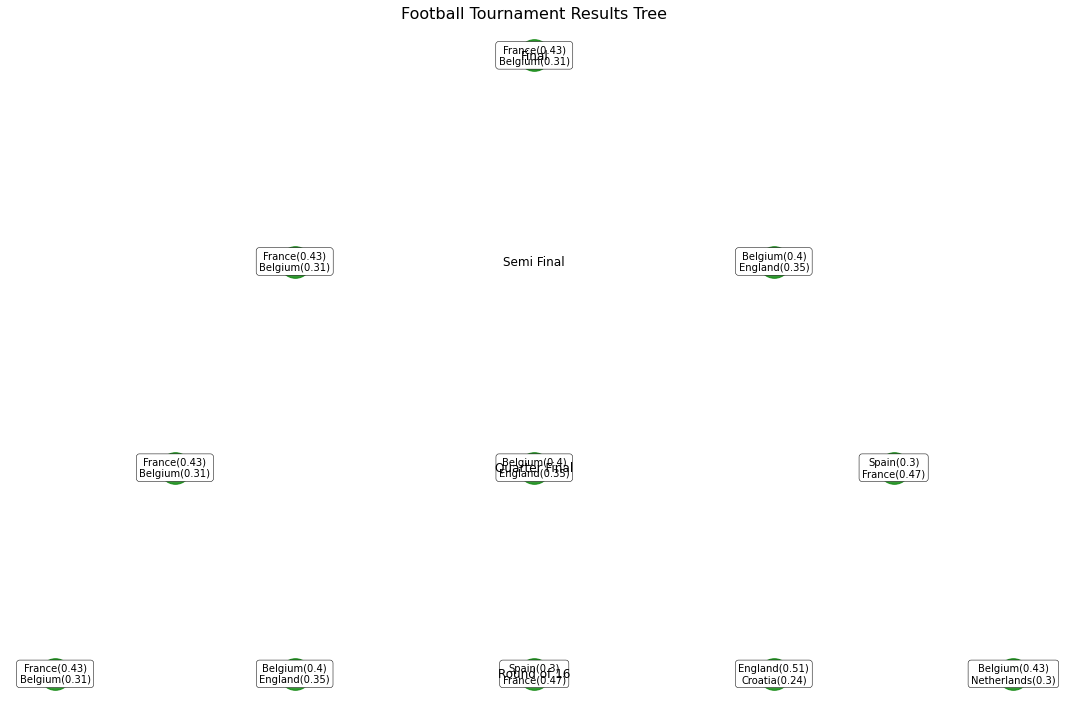

In [ ]:
# Create a figure and axis
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Calculate positions and labels
labels = []
for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)})\n{game[1]}({round(game[2][1], 2)})"
        labels.append(label)

labels_dict = {i: label for i, label in enumerate(reversed(labels))}

# Manually define positions for a balanced tree (adjust as needed)
levels = {
    'Final': [(0, 0)],
    'Semi Final': [(-2, -1), (2, -1)],
    'Quarter Final': [(-3, -2), (0, -2), (3, -2)],
    'Round of 16': [(-4, -3), (-2, -3), (0, -3), (2, -3), (4, -3)]
}

# Draw nodes
for round_name, pos_list in levels.items():
    y = -list(levels.keys()).index(round_name) * 2
    for idx, pos in enumerate(pos_list):
        x = pos[0]
        ax.scatter(x, y, s=1000, c='green', alpha=0.8)
        ax.text(x, y, labels_dict[idx], ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5))

# Add texts for rounds
for idx, round_name in enumerate(levels.keys()):
    ax.text(0, -idx * 2, round_name, ha='center', va='center', fontsize=12)

# Set plot title and adjust layout
ax.set_title('Football Tournament Results Tree', fontsize=16)
ax.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()
